# Question 1 : Plot Parking Meters on a map segmented by area. Which areas have the most poles?

## Show a map of san diego

In [64]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode

gis = GIS()

# Geocode the location of San Diego
location = geocode("San Diego")[0]

# Create a map centered at San Diego's location
san_diego_map = gis.map(location)
san_diego_map.basemap = 'streets'  
san_diego_map.zoom = 12

# Display the map
san_diego_map

MapView(layout=Layout(height='400px', width='100%'))

## Preprocess the dataset

In [166]:
import pandas as pd
import matplotlib.pyplot as plt

from arcgis.gis import GIS
from arcgis.mapping import *
from arcgis.geometry import *
from arcgis.features import *
from arcgis.geocoding import geocode
import math

df = pd.read_csv('/Users/anshuldevnani/Documents/school/ECE143/project/treas_parking_meters_loc_datasd.csv', usecols=["zone","pole","lat","lng", "area", "config_name"])
df_trans_2023 = pd.read_csv('/Users/anshuldevnani/Desktop/treas_meters_2023.csv')


df = df.rename(columns={"pole": "pole_id"})
filter_df = df [ df['config_name'] != "Sunday Mode" ]


df_trans_2023 = pd.read_csv('/Users/anshuldevnani/Desktop/treas_meters_2023.csv')
merge = pd.merge(df_trans_2023, filter_df, on='pole_id', how='left')

area_mapping = {"Core" : "Core - Columbia", "Columbia" : "Core - Columbia"}
merge['area'] = merge['area'].replace(area_mapping)



point = [] # list of dictionary
unique_pole_id = set()

# look at only unique ids
for _, row in merge.iterrows():
    pole_id = str(row['pole_id'])
    if pole_id not in unique_pole_id:
        latitude = float(row['lat'])
        longitude = float(row['lng'])
        area = str(row['area'])
        zone = str(row['zone'])
        point.append({'pole': pole_id, "lat":latitude, "long": longitude, "area": area, "zone":zone})
        unique_pole_id.add(pole_id)

        
# get rid of poles that dont have a mathcing location ~ about 20 of them
points_by_area={}
for p in point:
    area=p['area']
    if area == 'nan':
        continue
    if area not in points_by_area:
        points_by_area[area] = []
        
    points_by_area[area].append(p)

number_of_poles = {} # key : area,  value # number of poles
total_number_of_poles = 0
for area, info in points_by_area.items():
    number_of_poles[area] = len(info)
    total_number_of_poles += len(info)


number_of_poles_percentage = {}
for area, numberOfPoles in number_of_poles.items():
    number_of_poles_percentage[area] = (numberOfPoles / total_number_of_poles) * 100
    

color_mapping = {
    'Core': (255, 0, 0),              # Red
    'Core - Columbia': (0, 255, 0),    # Green
    'Cortez Hill': (0, 0, 255),        # Blue
    'Bankers Hill': (255, 255, 0),     # Yellow
    'Marina': (255, 0, 255),           # Magenta
    'Gaslamp': (0, 255, 255),          # Cyan
    'East Village': (128, 0, 0),       # Maroon
    'Hillcrest': (0, 128, 0),          # Green (dark)
    'Golden Hill': (0, 0, 128),        # Navy
    'North Park': (128, 128, 0),       # Olive
    'Cortez': (192, 192, 192),         # Silver
    'Point Loma': (128, 128, 128),     # Gray
    'Mission Hills': (64, 64, 64),     # Dark Gray
    'Barrio Logan': (255, 128, 0),     # Orange
    'Columbia': (255, 0, 128),         # Pink
    'Little Italy': (128, 255, 0),     # Lime
    'University Heights': (0, 128, 255),# Light Blue
    'Talmadge': (128, 0, 255),         # Purple (light)
    'Midtown': (128, 255, 128),        # Mint
    'College': (255, 128, 128),        # Salmon
    'Five Points': (255, 255, 128),    # Banana
    'Mission Beach': (128, 255, 255)   # Sky Blue
}





{'Core - Columbia': 10.553728070175438, 'Cortez Hill': 7.510964912280701, 'Bankers Hill': 13.240131578947366, 'Marina': 5.8936403508771935, 'Gaslamp': 6.1951754385964914, 'East Village': 22.697368421052634, 'Hillcrest': 14.199561403508772, 'Golden Hill': 0.3289473684210526, 'North Park': 2.1655701754385968, 'Cortez': 0.08223684210526315, 'Mission Hills': 3.070175438596491, 'Barrio Logan': 0.6030701754385964, 'Little Italy': 7.291666666666667, 'University Heights': 2.6589912280701755, 'Talmadge': 0.9046052631578948, 'Midtown': 0.3837719298245614, 'College': 0.1370614035087719, 'Five Points': 1.9188596491228072, 'Point Loma': 0.1644736842105263}


MapView(layout=Layout(height='400px', width='100%'))

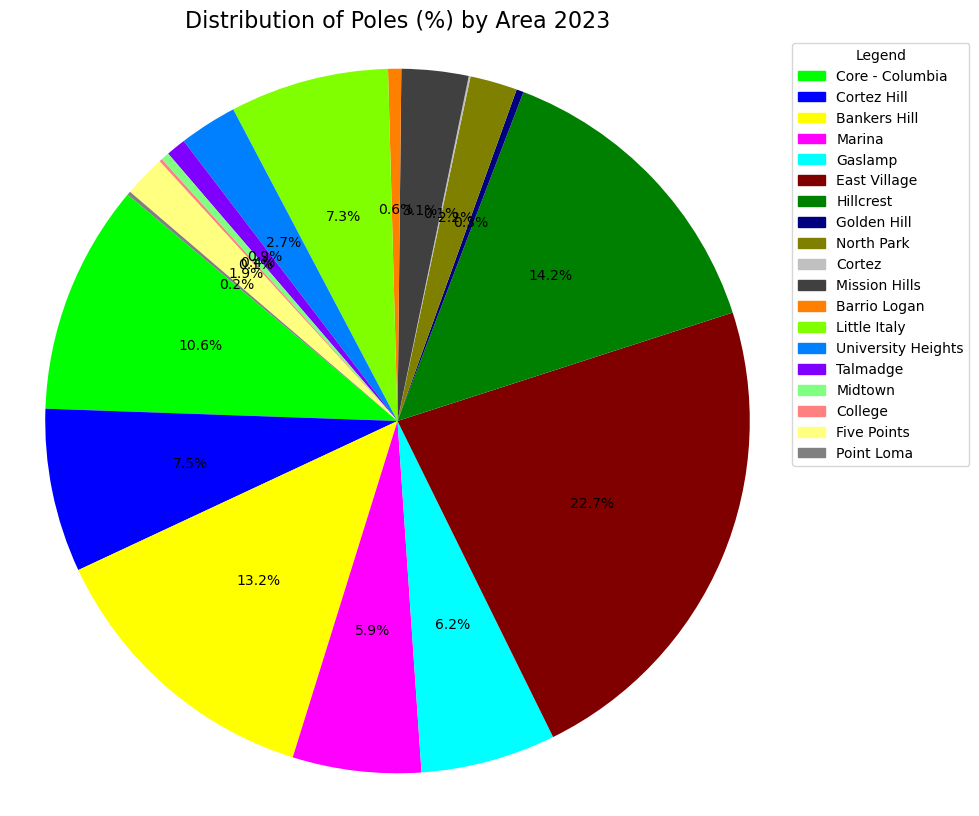

In [168]:
from matplotlib.patches import Patch
# Extract labels, sizes, and colors
labels = list(number_of_poles_percentage.keys())
sizes = list(number_of_poles_percentage.values())
colors = [tuple(map(lambda x: x / 255, color_mapping[label])) for label in labels]

# Create pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

legend_labels = [Patch(color=color, label=label) for label, color in zip(labels, colors)]
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title="Legend")

plt.title("Distribution of Poles (%) by Area 2023", fontsize=16)
# Show the plot
#plt.show()

output_image_path = 'pie_chart.png'
plt.savefig(output_image_path, bbox_inches='tight')


# Connect to your GIS (you may need to provide your own ArcGIS Online account credentials)
gis = GIS()

# Geocode the location of San Diego
location = geocode("San Diego")[0]

# Create a map centered at San Diego's location
san_diego_map = gis.map(location)
for area, poles in points_by_area.items():
    simple_marker_symbol = {
        "type": "esriSMS",
        "style": "esriSMSCircle",
        "color": color_mapping[area],
        "outline": {"color": [255, 255, 255], "width": .5},
        "size" : "5px"
    }

    features = []
    for point_info in poles:
        point_geometry = Point({"x": point_info['long'], "y": point_info['lat']})
        feature= Feature(geometry=point_geometry, attributes= {"ID" : point_info['pole'], "Lat" : point_info['lat'], "Long" : point_info['long'], "Area":point_info['area']})
        features.append(feature)

    # # Create a feature set from the features
    feature_set = FeatureSet(features)
    #print(feature_set.features[0].attributes)

    # # Draw the points on the map with the specified symbol

    san_diego_map.draw(
            shape=feature_set,
            symbol=simple_marker_symbol,
            attributes = feature_set.features,
            popup={
                "title" : "Area",
                "content": "Lat"
            }

        )

san_diego_map.zoom = 13
# Display the map
san_diego_map

# image_format = "png"

# # Export the map
# san_diego_map.export_image('./', resolution=96, format=image_format)